# **Performance Optimization in dlt pipelines**

### **Introduction**

Sometimes you have to slow down in order to speed up...

This lesson teaches you how to make dlt pipelines faster by optimizing each internal stage of execution. You’ll learn how to tune memory, enable parallelism, and reduce runtime using real examples.

We will walk through the internal steps of `pipeline.run()` again, but this time focusing only on performance optimization techniques.

Read more in the [dlt performance docs](https://dlthub.com/docs/general-usage/performance).



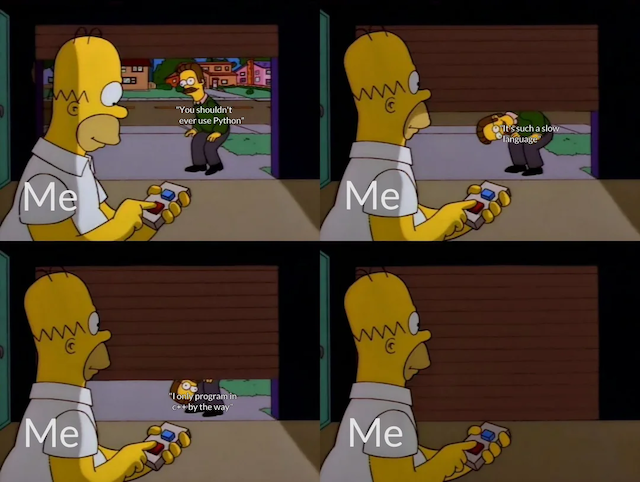

### **Already covered in Fundamentals**

- Basic structure of `pipeline.run()`.

- Default behavior of **extract/normalize/load**.

- Example with nested rows and `items__nested` tables.

- Overview of file formats (jsonl, parquet, etc.).

- Progress logging and pipeline introspection.

### **In the Advanced Performance Optimization lesson**

- Optimize memory with buffer tuning.

- Yield pages instead of rows.

- Control threading and multiprocessing.

- Tune file rotation for parallelism.

- Run multiple pipelines in one process.

- Spawn method on Linux.

- Real GitHub pipeline performance demo.

---

## Understanding `pipeline.run()` for Performance

When you call `pipeline.run()`, dlt goes through three stages:

1. **Extract** – fetch data and write intermediary files.
2. **Normalize** – transform and flatten the data.
3. **Load** – load data into the destination.

We'll now look at how to optimize each of these stages individually.

> If you're unfamiliar with how `pipeline.run()` works under the hood, including the **extract/normalize/load** stages and intermediary files, please complete the [Fundamentals module "How dlt works"](https://colab.research.google.com/drive/1geSMNRkSwAelQJKd3e8vdoHCKiHMdmIo#forceEdit=true&sandboxMode=true) first.

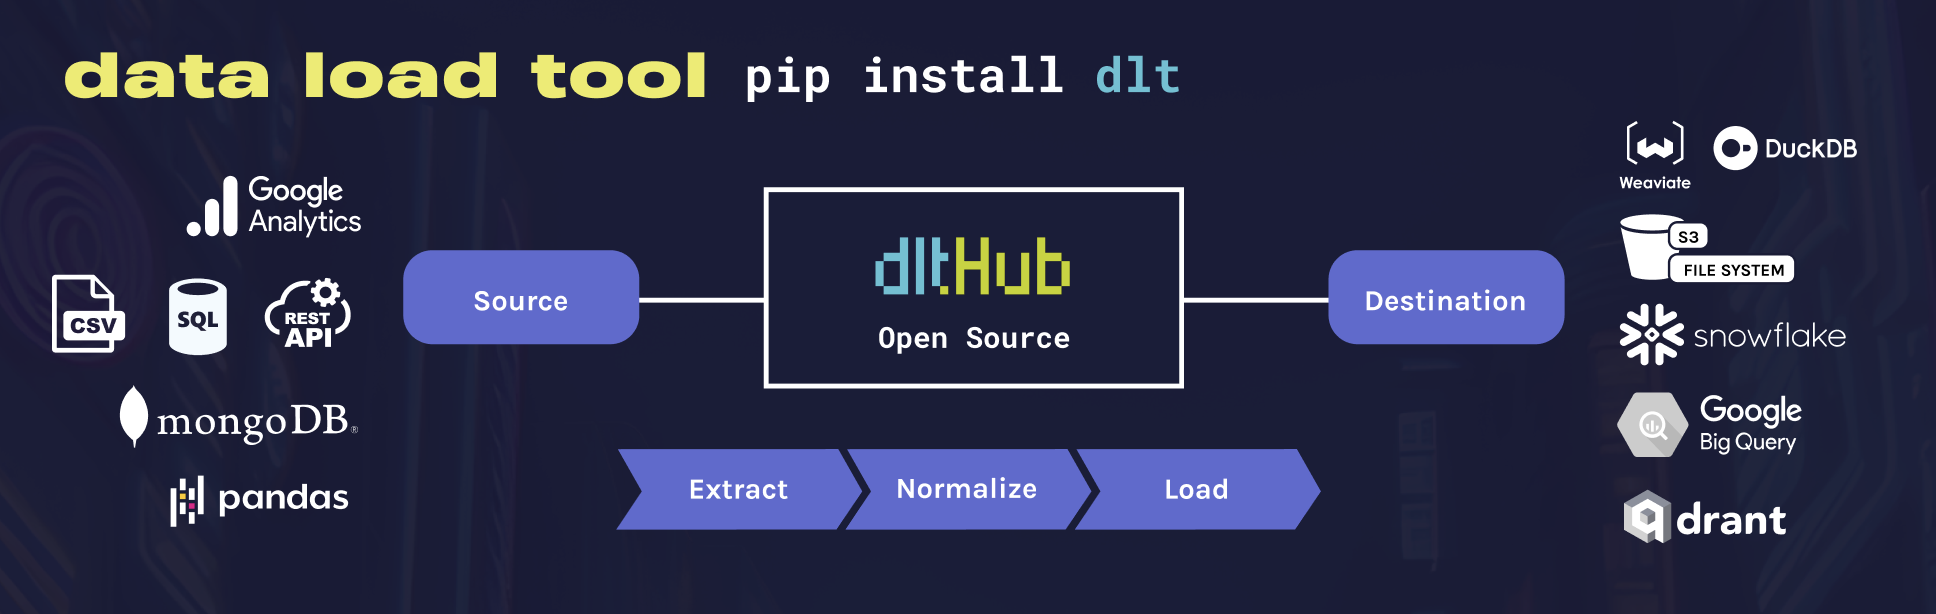


## **Before we dive into parallelism in dlt...**

To get the most out of parallelism features in `dlt`, it's helpful to quickly refresh how parallelism works in Python in general.

Python isn't truly multithreaded by default due to the Global Interpreter Lock (GIL), but there are multiple ways to run tasks concurrently: using **threads**, **processes**, or **async**.

Each has its own strengths, and `dlt` actually uses all of them depending on the stage: threads for extracting and loading, and processes for normalization.

Let’s take a quick look at how these work under the hood.

# **Parallelism in Python**


Python is single-threaded by default. That means only one operation happens at a time, even on multi-core CPUs. This becomes a bottleneck for:

- API calls
- file I/O
- database queries
- and anything that waits instead of computes

Parallelism solves this by doing *many things at once*. It’s essential when building efficient data pipelines, like those with `dlt`.


## **Types of parallelism in Python**

There are 3 main types. Each has different use cases.

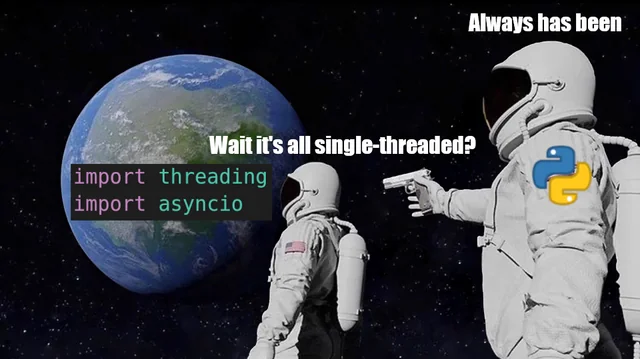



### 1. **Threading**
- Best for I/O-bound tasks (e.g., reading from APIs or files).
- Uses the `threading` or [`concurrent.futures.ThreadPoolExecutor`](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.ThreadPoolExecutor).



### **Why Python has multithreading — but only one thread runs Python code at a time**

- Python does support multithreading, and you can create multiple threads with `threading.Thread()`.

- But in CPython, the standard Python implementation, there’s something called the **Global Interpreter Lock (GIL)**.

- The GIL makes sure that only **one thread** can execute Python bytecode at a time — even on multi-core CPUs.

- So if you create 5 threads, Python will **run them one by one**, rapidly switching between them — not in true parallel.

- It still counts as “multithreading” because threads **exist and run**, but they’re **not truly concurrent** for Python code execution.

**Example 1:**

In this example, `threaded_function` prints the values zero to two that your for loop assigns to the loop variable number. Using a `ThreadPoolExecutor`, four threads are created to execute the threaded function. `ThreadPoolExecutor` is configured to run a maximum of four threads concurrently with `max_workers=4`, and each worker thread is named with a “Worker” prefix, as in `thread_name_prefix="Worker"`.

In [1]:
import threading
import time
from concurrent.futures import ThreadPoolExecutor

def threaded_function():
    for number in range(3):
        print(f"Printing from {threading.current_thread().name}. {number=}")
        # Simulate slow API call
        time.sleep(0.1)

with ThreadPoolExecutor(max_workers=4, thread_name_prefix="Worker") as executor:
    for _ in range(4):
        executor.submit(threaded_function)

Printing from Worker_0. number=0
Printing from Worker_1. number=0
Printing from Worker_2. number=0
Printing from Worker_3. number=0
Printing from Worker_0. number=1
Printing from Worker_1. number=1
Printing from Worker_2. number=1
Printing from Worker_3. number=1
Printing from Worker_0. number=2
Printing from Worker_1. number=2
Printing from Worker_2. number=2
Printing from Worker_3. number=2


### 2. **Multiprocessing**
- Best for CPU-bound tasks (e.g., compressing, parsing, transforming).
- Uses `multiprocessing` or [`concurrent.futures.ProcessPoolExecutor`](https://docs.python.org/3/library/concurrent.futures.html#processpoolexecutor).

Example 1:

In this example, `compute_heavy_task` squares numbers from 0 to 2 and prints the process name it runs on. We use `ProcessPoolExecutor` to run 4 processes in parallel, each computing the task independently.

In [2]:
import multiprocessing
import time
from concurrent.futures import ProcessPoolExecutor

def compute_heavy_task():
    for number in range(3):
        print(f"Computing in {multiprocessing.current_process().name}. {number=} => {number**2}\n")
        time.sleep(0.1)


if __name__ == "__main__":
    with ProcessPoolExecutor(max_workers=4) as executor:
        for _ in range(4):
            executor.submit(compute_heavy_task)


Computing in ForkProcess-1. number=0 => 0
Computing in ForkProcess-3. number=0 => 0
Computing in ForkProcess-4. number=0 => 0

Computing in ForkProcess-2. number=0 => 0



Computing in ForkProcess-1. number=1 => 1
Computing in ForkProcess-3. number=1 => 1


Computing in ForkProcess-4. number=1 => 1

Computing in ForkProcess-2. number=1 => 1

Computing in ForkProcess-1. number=2 => 4

Computing in ForkProcess-3. number=2 => 4

Computing in ForkProcess-4. number=2 => 4

Computing in ForkProcess-2. number=2 => 4



Example 2:

In [3]:
import concurrent.futures
import math

PRIMES = [
    112272535095293,
    112582705942171,
    112272535095293,
    115280095190773,
    115797848077099,
    1099726899285419]

def is_prime(n):
    if n < 2:
        return False
    if n == 2:
        return True
    if n % 2 == 0:
        return False

    sqrt_n = int(math.floor(math.sqrt(n)))
    for i in range(3, sqrt_n + 1, 2):
        if n % i == 0:
            return False
    return True


with concurrent.futures.ProcessPoolExecutor() as executor:
    for number, prime in zip(PRIMES, executor.map(is_prime, PRIMES)):
        print('%d is prime: %s' % (number, prime))

112272535095293 is prime: True
112582705942171 is prime: True
112272535095293 is prime: True
115280095190773 is prime: True
115797848077099 is prime: True
1099726899285419 is prime: False


### 3. **AsyncIO**
- Great for many concurrent tasks that *wait* (e.g., HTTP, sockets).
- Lightweight and fast. Single-threaded but concurrent.



Example 1:

In [4]:
import asyncio

async def main():
    await asyncio.sleep(1)
    print('hello')

# In Colab, you'll need to get a handle of the current running loop first.
loop = asyncio.get_running_loop()
await loop.create_task(main())

hello


Example 2:

The order of this output is **the heart of async IO**. Talking to each of the calls to `count()` is a single event loop, or coordinator.

When each task reaches `await asyncio.sleep(1)`, the function yells up to the event loop and gives control back to it, saying, **“I’m going to be sleeping for 1 second. Go ahead and let something else meaningful be done in the meantime.”**

In [5]:
import asyncio
import time


async def count():
    print("One")
    await asyncio.sleep(1)
    print("Two")

async def main():
    await asyncio.gather(count(), count(), count())



s = time.perf_counter()

# In Colab, you'll need to get a handle of the current running loop first.
loop = asyncio.get_running_loop()
await loop.create_task(main())

elapsed = time.perf_counter() - s
print(f"executed in {elapsed:0.2f} seconds.")

One
One
One
Two
Two
Two
executed in 1.00 seconds.



---

# **Parallelism in dlt**

In `dlt`, parallelism is baked in:

- **Extraction**: via threads (`parallelized=True` in `@dlt.resource`) or async generators.
- **Normalization**: via process pools.
- **Loading**: via threads.




---

## **Extract**

The extract stage fetches data and writes it to intermediary files. This phase is usually **I/O-bound** — lots of small writes or slow network calls can slow it down.



### **Default behaviour**

- The in-memory buffer is set to `5000` items.
- By default, **intermediary files are not rotated**. If you do not explicitly set a size for an intermediary file with `file_max_items=100000`, `dlt` will create a **single file** for a resource, regardless of the number of records it contains, even if it reaches millions.
- By default, intermediary files at the extract stage use a custom version of the JSONL format.

### **How to optimize extraction?**

- Control the [in-memory buffer size](#scrollTo=ffVpDFHfnqO-) for the extract stage
- Group `dlt` resources into `dlt` sources
- Specify the number of thread workers or..
- When using async generators, control the number of async functions/awaitables being evaluated in parallel
- Yield pages instead of rows
- Customize the [size of intermediary files](#scrollTo=g9AGWfLkoAMb) created in the extract stage to control file rotation

### **IMPORTANT: Start simple. dlt has smart defaults**

Before you dive into tuning buffers, tweaking file sizes, and parallelizing every little thing — consider this:

> **`dlt` comes with well-thought-out defaults that work great for most cases.**

The default settings are:
- Conservative enough to work on a laptop.
- Efficient enough to run production loads for many use cases.
- Safe to experiment with incrementally.

#### When to start tweaking?

Once you’ve:
- Run your pipeline end-to-end successfully.
- Noticed slowdowns at scale.
- Understood which part of the pipeline (extract, normalize, load) is the bottleneck.

> **Start with the defaults. Measure. Then tune.**


### **1. [Use a larger In-Memory Buffer](https://dlthub.com/docs/reference/performance#overall-memory-and-disk-management)**

dlt **buffers** data **in memory** to speed up processing and uses the file system to pass data between the **extract** and **normalize** stages.

You can control **the size of the buffers** and **the size and number of the files** to fine-tune memory and CPU usage. These settings also impact parallelism.

The size of the buffers is controlled by specifying **the number of data items** held in them. Data is appended to open files when the item buffer is full, after which the buffer is cleared.

By default, dlt **buffers 5000 items** before writing to disk. Increase this value to reduce disk I/O and improve speed.


In [6]:
%%capture
!pip install -U dlt

Example 1:

We set the buffer size to 1. dlt will extract data **row by row** and write each row to an intermediary file one by one.

This also **disables multithreading** — when the buffer size is 1, the number of extract workers is effectively limited to 1.

In [7]:
import os
import dlt

os.environ['DATA_WRITER__BUFFER_MAX_ITEMS'] = '1'

def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))


@dlt.resource()
def buffered_resource():
    for row in get_rows(500000):
        yield row

pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline1", destination="duckdb", dataset_name="mydata", dev_mode=True,
)
load_info = pipeline.extract(buffered_resource)
print(pipeline.last_trace)

Run started at 2025-05-10 16:56:08.963375+00:00 and COMPLETED in 10.22 seconds with 1 steps.
Step extract COMPLETED in 10.22 seconds.

Load package 1746896168.976712 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs


Example 2:

Increase the number of buffer items.

In [8]:
import os
import dlt

os.environ['DATA_WRITER__BUFFER_MAX_ITEMS'] = '5000'

def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))


@dlt.resource()
def buffered_resource():
    for row in get_rows(500000):
        yield row

pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline2", destination="duckdb", dataset_name="mydata", dev_mode=True,
)
load_info = pipeline.extract(buffered_resource)
print(pipeline.last_trace)

Run started at 2025-05-10 16:56:23.909073+00:00 and COMPLETED in 7.02 seconds with 1 steps.
Step extract COMPLETED in 7.01 seconds.

Load package 1746896183.9203079 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs


**Explanation:** The buffer collects many items in memory before writing them to disk. A larger buffer means fewer writes, which saves I/O time and makes the extract stage faster. This is especially helpful when extracting a large number of small records.

**Downside:** High buffer size increases memory usage. If the machine has limited RAM, it could cause memory pressure or crashes.


**IMPORTANT: Performance measurements in Google Colab may be unreliable.**

Even with large buffer sizes, timing results in Colab can vary significantly between runs. This is because Colab runs on shared cloud infrastructure, where CPU, memory, and disk I/O are not guaranteed and may fluctuate at any time.

You might observe:

- Slower or inconsistent extract times

- Unpredictable delays due to resource throttling or background activity

For **reliable performance** testing, always run your dlt pipelines on a **local machine**, where you control the environment and system resources are stable.

#### **Excercise 1**

Play with `BUFFER_MAX_ITEMS` parameter. Run your pipeline and measure the time.

Don’t expect linear speed-up — larger buffers may **slow things down** depending on your system.

At some point, increasing the buffer size will **stop making things faster**. After that threshold, you’ll hit diminishing returns, and performance may plateau or even degrade. The optimal value depends on your machine’s I/O and memory characteristics.

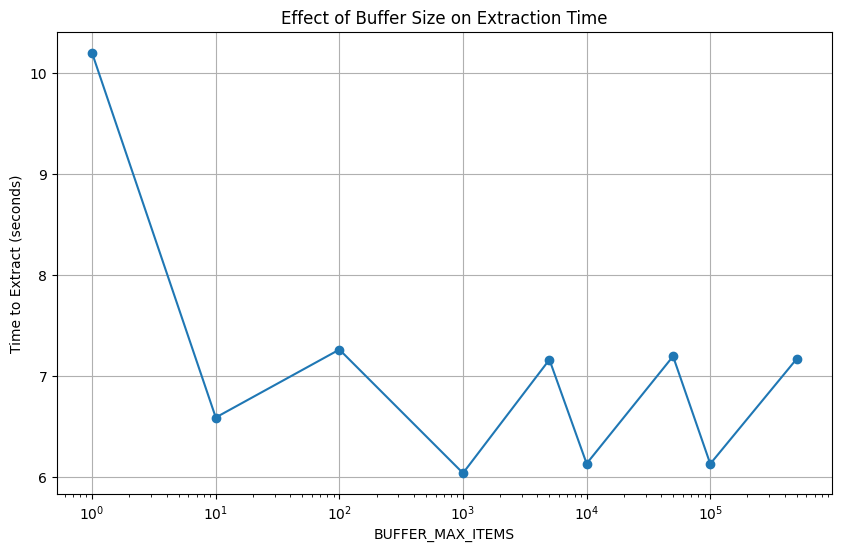

In [9]:
import os
import time
import dlt
import matplotlib.pyplot as plt


def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))


def measure_extract_time(buffer_size):
    os.environ['DATA_WRITER__BUFFER_MAX_ITEMS'] = str(buffer_size)

    @dlt.resource()
    def buffered_resource():
        for row in get_rows(500000):
            yield row

    pipeline = dlt.pipeline(
        pipeline_name=f"extract_pipeline_{buffer_size}",
        destination="duckdb",
        dataset_name="mydata",
        dev_mode=True,
    )

    start_time = time.time()
    pipeline.extract(buffered_resource)
    return time.time() - start_time


# Try different buffer sizes
buffer_sizes = [1, 10, 100, 1000, 5000, 10000, 50000, 100000, 500000]
times = [measure_extract_time(size) for size in buffer_sizes]


plt.figure(figsize=(10, 6))
plt.plot(buffer_sizes, times, marker='o')
plt.xlabel('BUFFER_MAX_ITEMS')
plt.ylabel('Time to Extract (seconds)')
plt.title('Effect of Buffer Size on Extraction Time')
plt.grid(True)
plt.xscale('log')
plt.show()


### **2. Group Resources into Sources**

In `dlt`, each **resource** is treated as a separate unit during extraction. If you pass multiple resources directly to `pipeline.extract()`, `dlt` handles them independently — each with its own extract process and context.

To **optimize performance**, especially during the extract stage, it's often better to **group related resources into a single source**. This allows `dlt` to:
- Run extraction more efficiently
- Reuse shared context (like API sessions or connections)
- Avoid overhead from managing multiple resource objects individually
- Enable better parallelism and state management


Example without grouping:



In [10]:
exit()

In [1]:
import os
import dlt

def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))

@dlt.resource(name="resource1")
def buffered_resource1():
    for row in get_rows(500000):
        yield row


@dlt.resource(name="resource2")
def buffered_resource2():
    for row in get_rows(500000):
        yield row


@dlt.resource(name="resource3")
def buffered_resource3():
    for row in get_rows(500000):
        yield row



pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline4",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)

load_info = pipeline.extract([buffered_resource1, buffered_resource2, buffered_resource3])
print(pipeline.last_trace)

Run started at 2025-05-10 16:59:30.058827+00:00 and COMPLETED in 23.66 seconds with 1 steps.
Step extract COMPLETED in 23.66 seconds.

Load package 1746896370.1213272 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs


This works, but each resource is treated separately. For large datasets or many resources, this adds extract overhead.


Example with grouping:


In [2]:
import os
import time
import dlt
from threading import currentThread


@dlt.source
def source():
  return buffered_resource1, buffered_resource2, buffered_resource3


pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline4",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)

load_info = pipeline.extract(source())
print(pipeline.last_trace)

Run started at 2025-05-10 16:59:57.736112+00:00 and COMPLETED in 19.67 seconds with 1 steps.
Step extract COMPLETED in 19.67 seconds.

Load package 1746896397.7534738 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs



This version:
- Groups all resources into a single source
- Allows `dlt` to optimize scheduling and state tracking
- Reduces overhead during extraction and improves throughput

####  **What to expect**

- **Grouped resources** may not show a big speed increase in small examples.
- However, **it unlocks `dlt`'s parallel extraction engine**: when grouped into a single `@dlt.source`, `dlt` can schedule their execution in a shared thread pool.
- This is essential when working with:
  - Many resources
  - Slow APIs
  - IO-bound extractors
  - High data volumes

#### **Note**:
Even if timing results look similar in this example, grouping into a source is what **enables true concurrent resource execution**. Without it, `dlt` treats each resource as an isolated unit and may serialize extraction.


### **3. Enable parallel threaded extraction**

When extracting data from **multiple sources**, you usually want them to be processed **at the same time**, not one after another. This is especially useful when:

- Calling **slow APIs**
- Working with **multiple endpoints**
- Extracting from **databases with many tables**

Use multiple threads to fetch data from different resources with `parallelized=True`.

Set the number of parallel threads with:

```python
os.environ["EXTRACT__WORKERS"] = "3"
```

**Simulate Slow APIs with `time.sleep`**

We’ll simulate API latency by adding a `time.sleep(0.01)` delay before yielding each row. This mimics a network call taking ~10ms.

We’ll then parallelize the resources using `parallelized=True` and observe the thread behavior using `threading.currentThread()`.


In [3]:
import os
import dlt
import time
from threading import current_thread

def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))

# Resource 1: slow generator, runs in a separate thread
@dlt.resource(name="resource1", parallelized=False)
def buffered_resource1():
    for row in get_rows(100):
        time.sleep(0.01)  # Simulate slow API call
        print(f"resource1 in thread {current_thread().name}")
        yield row


@dlt.resource(name="resource2", parallelized=False)
def buffered_resource2():
    for row in get_rows(100):
        time.sleep(0.01)
        print(f"resource2 in thread {current_thread().name}")
        yield row


@dlt.resource(name="resource3", parallelized=False)
def buffered_resource3():
    for row in get_rows(100):
        time.sleep(0.01)
        print(f"resource3 in thread {current_thread().name}")
        yield row


@dlt.source
def source():
    return buffered_resource1, buffered_resource2, buffered_resource3


pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline4",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)


load_info = pipeline.extract(source())
print(pipeline.last_trace)

resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource

**What does it mean?**

dlt is extracting rows in a [**round-robin**](https://dlthub.com/docs/reference/performance#resources-extraction-fifo-vs-round-robin) fashion — one row from each resource in turn — all within the `MainThread`. Since there’s no parallelization, the resources share a single thread and are executed sequentially.

**Now let’s enable multithreading.**

In the previous example, all resources ran sequentially in the main thread. This time, we add `parallelized=True` to each resource — allowing `dlt` to extract from all three **at the same time**, using separate threads.

You’ll see the difference immediately in the output: each resource prints from a different thread, confirming that extraction is now concurrent.

In [4]:
import os
import dlt
import time
from threading import current_thread

def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))


# Resource 1: slow generator, runs in a separate thread
@dlt.resource(name="resource1", parallelized=True)
def buffered_resource1():
    for row in get_rows(100):
        time.sleep(0.01)  # Simulate slow API call
        print(f"resource1 in thread {current_thread().name}")
        yield row


@dlt.resource(name="resource2", parallelized=True)
def buffered_resource2():
    for row in get_rows(100):
        time.sleep(0.01)
        print(f"resource2 in thread {current_thread().name}")
        yield row


@dlt.resource(name="resource3", parallelized=True)
def buffered_resource3():
    for row in get_rows(100):
        time.sleep(0.01)
        print(f"resource3 in thread {current_thread().name}")
        yield row


@dlt.source
def source():
    return buffered_resource1, buffered_resource2, buffered_resource3


pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline4",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)


load_info = pipeline.extract(source())
print(pipeline.last_trace)

resource1 in thread dlt-pool-133366436945920-threads_0resource2 in thread dlt-pool-133366436945920-threads_1
resource3 in thread dlt-pool-133366436945920-threads_2

resource3 in thread dlt-pool-133366436945920-threads_1
resource2 in thread dlt-pool-133366436945920-threads_0
resource1 in thread dlt-pool-133366436945920-threads_2
resource3 in thread dlt-pool-133366436945920-threads_1
resource2 in thread dlt-pool-133366436945920-threads_0
resource1 in thread dlt-pool-133366436945920-threads_2
resource2 in thread dlt-pool-133366436945920-threads_0
resource3 in thread dlt-pool-133366436945920-threads_1
resource1 in thread dlt-pool-133366436945920-threads_2
resource2 in thread dlt-pool-133366436945920-threads_0
resource3 in thread dlt-pool-133366436945920-threads_2
resource1 in thread dlt-pool-133366436945920-threads_1
resource3 in thread dlt-pool-133366436945920-threads_1
resource2 in thread dlt-pool-133366436945920-threads_0
resource1 in thread dlt-pool-133366436945920-threads_2
resource3 

**Explanation:** Each worker runs in a separate thread, allowing several resources to extract data at the same time. This is critical for reducing bottlenecks when working with slow APIs or large resource sets.

**Downside:** More threads increase CPU load. Poorly written thread-unsafe code or thread contention may degrade performance instead of improving it.


### **Async**

The example below does the same but using an async generator as the main resource and async/await and futures pool for the transformer.

**Example 1 — Synchronous execution (sequential, slow)**

In [5]:
import time
import dlt

@dlt.resource
def sync_items():
    for i in range(10):
        time.sleep(0.5)  # Blocking call
        yield i


@dlt.transformer
def sync_transform(item):
    time.sleep(0.5)  # Also blocking
    return {"row": item}


start = time.time()
result = list(sync_items() | sync_transform)
print(f"Sync result: {result}")
print("Sync elapsed time:", round(time.time() - start, 2), "seconds")


Sync result: [{'row': 0}, {'row': 1}, {'row': 2}, {'row': 3}, {'row': 4}, {'row': 5}, {'row': 6}, {'row': 7}, {'row': 8}, {'row': 9}]
Sync elapsed time: 10.02 seconds


**Example 2 — Asynchronous execution (concurrent, fast)**

In [6]:
import asyncio
import time
import dlt

@dlt.resource
async def async_items():
    for i in range(10):
        await asyncio.sleep(0.5)  # Blocking
        yield i


@dlt.transformer
async def async_transform(item):
    await asyncio.sleep(0.5)  # Non-blocking
    # just return the results, if you yield, generator will be evaluated in main thread
    return {"row": item}


start = time.time()
print(list(async_items() | async_transform))
print("Async elapsed time:", round(time.time() - start, 2), "seconds")


[{'row': 0}, {'row': 1}, {'row': 2}, {'row': 3}, {'row': 4}, {'row': 5}, {'row': 6}, {'row': 7}, {'row': 8}, {'row': 9}]
Async elapsed time: 5.53 seconds


**Breakdown of time**

- `async_items()` yields 10 items → takes ~5s total (0.5s × 10)

- `async_transform()` is fast once it starts — runs in parallel

- So total time is:

  - ~5s to yield

  - `+` ~0.5s to process the last batch of transformer calls

  - ➜ ~5.5–6 seconds total

### **4. Yielding chunks instead of rows**

In real-world data extraction, especially from APIs, **data is typically returned in pages** — for example, 100 users per request. These pages are already **natural chunks**, so there's no reason to extract and yield each row from the page individually.

Instead of doing something like:

```python
for item in page:
    yield item  # ❌ inefficient
```

You should just do:

```python
yield page  # ✅ fast and efficient
```

This small change makes a big difference in performance. Yielding full pages (chunks) reduces the number of Python function calls and lets `dlt` process your data more efficiently — especially during buffering and writing stages.

#### **What is `yield` in Python?**

In Python, `yield` turns a function into a **generator**.

Instead of returning a full list of results at once, it gives back **one item at a time**, each time the function is called again.

This is useful when:
- You work with large datasets
- You don’t want to keep everything in memory
- You want to stream values as they are produced

#### Example

In [7]:
def count_up_to(n):
    for i in range(n):
        yield i

Calling `count_up_to(3)` returns a generator:

In [8]:
for number in count_up_to(3):
    print(number)

0
1
2


#### **Yielding rows in dlt**

This is what you usually see in basic educational `dlt` pipelines:

In [9]:
def fetch_users():
  return [{"id": 1}, {"id": 2}, {"id": 3}]


@dlt.resource
def get_users():
    for user in fetch_users():
        yield user  # yields one row at a time


#### Problem

This creates a **high number of `yield` calls** — each row is passed into the extract pipeline one at a time. While dlt buffers rows before writing, each row still incurs the cost of a Python function call and per-item processing inside the pipeline.

This adds overhead, especially with millions of rows.


#### **What does “Yield Chunks” mean?**

Instead of:

```python
yield {"id": 1}
yield {"id": 2}
```

Do this:

```python
yield [{"id": 1}, {"id": 2}]  # yield a list of rows
```

We call this **page/chunk-based yielding**.

You still use `yield`, but now each yield returns **a batch of rows**, not just one.




#### **How to yield chunks**

Here’s how you chunk your data with `islice` from `itertools`:

In [10]:
import os
import dlt
import time
from threading import current_thread
from itertools import islice

def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))


def yield_chunks(iterable, chunk_size=10):
    iterator = iter(iterable)
    while chunk := list(islice(iterator, chunk_size)):  # <--- we slice data into chunks
        time.sleep(0.01)  # Simulate slow API call
        yield chunk


# Chunked resources, run in parallel threads
@dlt.resource(name="resource1", parallelized=True)
def buffered_resource1():
    yield from yield_chunks(get_rows(100), chunk_size=10)


@dlt.resource(name="resource2", parallelized=True)
def buffered_resource2():
    yield from yield_chunks(get_rows(100), chunk_size=10)


@dlt.resource(name="resource3", parallelized=True)
def buffered_resource3():
    yield from yield_chunks(get_rows(100), chunk_size=10)


@dlt.source
def source():
    return buffered_resource1, buffered_resource2, buffered_resource3


pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline4",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)

load_info = pipeline.extract(source())
print(pipeline.last_trace)


Run started at 2025-05-10 17:04:34.662349+00:00 and COMPLETED in 0.19 seconds with 1 steps.
Step extract COMPLETED in 0.19 seconds.

Load package 1746896674.6733866 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs



Such a crazy speed improvement! You'll notice the difference even more as your data size grows.

### **5. Enable file rotation for large datasets**  

By default, `dlt` writes all extracted data from a resource into **one large intermediary file**. If your resource yields millions of rows, that means:
- Only **one normalization worker** will be able to process that file
- You’ll lose all benefits of **parallel processing** in later stages

To fix this, you can **enable file rotation** by setting a file size limit. For example:

```python
os.environ["EXTRACT__DATA_WRITER__FILE_MAX_ITEMS"] = "100000"
```

This means:
- Every 100,000 items, a new intermediary file will be created
- If you have 1,000,000 rows, you'll end up with 10 files
- Later, these files can be processed **in parallel** during normalization and load

File rotation is essential for scaling up performance when dealing with large datasets.



### **6. Avoid unnecessary transformation in the resource**  
   Keep your resource logic simple and fast — avoid costly computation or transformation in the generator itself.

## **Normalize**

### **What happens at the normalization stage?**

After data is extracted, `dlt` transforms it into a **relational format** suitable for loading into databases. This happens in the **normalize stage**:

1. Extracted files are passed to the **normalization process pool**.
2. Each file is read, schema is resolved, and data is transformed.
3. Rows are buffered and written into **normalized intermediary files**.
4. These files are then used in the **load** stage.


>If you’re not yet familiar with how the **normalization stage** works in `dlt`, we recommend reviewing the [**Normalization section in the dlt Fundamentals course**](https://colab.research.google.com/drive/1geSMNRkSwAelQJKd3e8vdoHCKiHMdmIo#forceEdit=true&sandboxMode=true&scrollTo=bCeUqaW_cRSh) before diving into performance tuning.  


### **Default behavior**

- **Buffer size**: 5,000 items
- **Parallelism**: Off by default (runs in main process)
- **File rotation**: Off by default — all rows written into one file
- **Compression**: On by default


### **Why normalization may be slow**

If you process a lot of data in one file and use just one CPU, normalization becomes a bottleneck:
- File parsing and transformation are **CPU-heavy**
- Without parallelism, large files block the pipeline
- Compression slows it further if not needed

> File parsing and transformation are **CPU-heavy**, especially when dealing with **deeply nested structures** (which must be flattened into multiple tables) and **automatic data type inference** (which inspects each value to determine its type).



### How to optimize normalization

1. **Enable parallelism**: Use multiple processes
   ```python
   os.environ['NORMALIZE__WORKERS'] = '3'
   ```

2. **Disable compression (for debugging or speed)**:
   ```python
   os.environ['NORMALIZE_DATA_WRITER__DISABLE_COMPRESSION'] = 'true'
   ```

3. **Control buffer size** (optional):
   ```python
   os.environ['NORMALIZE__DATA_WRITER__BUFFER_MAX_ITEMS'] = '10000'
   ```

4. **Enable file rotation** (if you have one big file):
   ```python
   os.environ['NORMALIZE__DATA_WRITER__FILE_MAX_ITEMS'] = '100000'
   ```


### **1. Parallel normalization**

Let’s measure normalization performance with and without parallelism.



#### **a. Normalize with 1 worker (default)**

First, we run extraction:

In [11]:
%%capture
!pip install -U dlt

In [12]:
import os
import dlt
import time
from threading import current_thread
from itertools import islice


def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))


def yield_chunks(iterable, chunk_size=10):
    iterator = iter(iterable)
    while chunk := list(islice(iterator, chunk_size)):  # <--- we slice data into chunks
        time.sleep(0.01)  # Simulate slow API call
        yield chunk


# Chunked resources, run in parallel threads
@dlt.resource(name="resource1", parallelized=True)
def buffered_resource1():
    yield from yield_chunks(get_rows(1000000), chunk_size=10000)


@dlt.resource(name="resource2", parallelized=True)
def buffered_resource2():
    yield from yield_chunks(get_rows(1000000), chunk_size=10000)


@dlt.source
def source():
    return buffered_resource1, buffered_resource2


pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline_w1",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)

load_info = pipeline.extract(source())
print(pipeline.last_trace)


Run started at 2025-05-10 17:08:34.670004+00:00 and COMPLETED in 5.05 seconds with 1 steps.
Step extract COMPLETED in 5.05 seconds.

Load package 1746896914.8867776 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs


As mentioned earlier, each file created during the extract stage is sent to the process pool of the normalization stage. Since file rotation has not been enabled at the extract stage, each resource is written to a separate intermediary file. This results in **three files**, which can be **normalized in parallel**.

First, let's measure the time taken with a single process worker.

In [13]:
import os
import time

os.environ['NORMALIZE__WORKERS'] = '1'

load_info = pipeline.normalize()
print(pipeline.last_trace)

Run started at 2025-05-10 17:08:34.670004+00:00 and COMPLETED in 1 minute and 18.03 seconds with 2 steps.
Step extract COMPLETED in 5.05 seconds.

Load package 1746896914.8867776 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 57.22 seconds.
Normalized data for the following tables:
- resource1: 1000000 row(s)
- resource2: 1000000 row(s)
- _dlt_pipeline_state: 1 row(s)

Load package 1746896914.8867776 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs


Oh, that took way longer than extraction, right?  

Yep, that’s totally normal. The **normalization step does the heavy lifting**:
- flattening nested data,
- figuring out types,
- generating tables.

It’s often **the slowest part** of the pipeline, so don’t be surprised if it takes most of the time.



#### **b. Normalize with 2 workers**

Now, let's try more process workers.

Unfortunately, Colab gives us only **2 CPU cores**.  
That means running normalization with more than 2 workers won’t help (and might even slow things down).  
Let’s stick with **2 workers** to get the best performance from what we’ve got!


Note that we are running the extract stage again with a new pipeline, because normalizing already normalized data would not be meaningful.

In [14]:
import os
os.cpu_count()


2

In [15]:
# Set the number of process workers to 2
os.environ['NORMALIZE__WORKERS'] = '2'

pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline_w2",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)


load_info = pipeline.extract(source())
load_info = pipeline.normalize()

print(pipeline.last_trace)

Run started at 2025-05-10 17:10:03.506568+00:00 and COMPLETED in 56.89 seconds with 2 steps.
Step extract COMPLETED in 2.78 seconds.

Load package 1746897003.517931 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 54.10 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- resource1: 1000000 row(s)
- resource2: 1000000 row(s)

Load package 1746897003.517931 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs




#### What to expect

With parallel workers:
- The total time to normalize **drops significantly**
- CPU usage will increase (expected!)
- Logs may show multiple files being processed at the same time


#### ✅ Rule of thumb:
Use more workers and rotate files if you have:
- Large data
- Multiple extracted files
- A machine with multiple CPU cores


### **2. Enable file rotation for large datasets**  

By default, all normalized data goes into **one big file** — which means **only one process** can handle it. That kills parallelism.

To fix this, set:

```python
os.environ["NORMALIZE__DATA_WRITER__FILE_MAX_ITEMS"] = "100000"
```

Now `dlt` will:
- Split data into smaller files (e.g., 10 files for 1M rows)
- Load them **in parallel** using multiple workers
- Speed up loading




## **Load**



### **What happens at the loading stage?**



After data is normalized, `dlt` takes the resulting files and sends them to your **destination** (e.g., DuckDB, BigQuery, Redshift).

This stage uses a **thread pool**, where:
1. Each thread loads one normalized file at a time.
2. Files from the same source are bundled into a **load package**.
3. Packages are loaded into the destination concurrently.





### **Default behavior**

- `dlt` uses **20 threads** by default
- Each thread processes one file
- All file contents are already normalized — there’s no parsing or schema detection at this point, so it’s mostly **I/O-bound**

### **How to optimize loading?**


1. **Control the number of threads**  
   Set this based on your destination’s capacity:

   ```python
   os.environ["LOAD__WORKERS"] = "4"
   ```

2. **Rotate files during normalization**  
   If all your data is in **one big file**, you’ll still have only **one load job**. To unlock real parallelism:
   ```python
   os.environ["NORMALIZE__DATA_WRITER__FILE_MAX_ITEMS"] = "100000"
   ```


### **Example**

Now that we have two pipelines from the previous steps, let's use the first one to load data with only one thread. This means all normalized files will be loaded sequentially.

In [16]:
%%capture
!pip install -U dlt

In [17]:
import os
import dlt
import time
from threading import current_thread
from itertools import islice


def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))


def yield_chunks(iterable, chunk_size=10):
    iterator = iter(iterable)
    while chunk := list(islice(iterator, chunk_size)):  # <--- we slice data into chunks
        time.sleep(0.01)  # Simulate slow API call
        yield chunk


# Chunked resources, run in parallel threads
@dlt.resource(name="resource1", parallelized=True)
def buffered_resource1():
    yield from yield_chunks(get_rows(1000000), chunk_size=10000)


@dlt.resource(name="resource2", parallelized=True)
def buffered_resource2():
    yield from yield_chunks(get_rows(1000000), chunk_size=10000)



@dlt.resource(name="resource3", parallelized=True)
def buffered_resource3():
    yield from yield_chunks(get_rows(1000000), chunk_size=10000)


@dlt.source
def source():
    return buffered_resource1, buffered_resource2, buffered_resource3


In [18]:
# Set the number of thread workers to 1
os.environ['LOAD__WORKERS'] = '1'

pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline_load1",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)


pipeline.extract(source())
pipeline.normalize()
pipeline.load()


print(pipeline.last_trace)

Run started at 2025-05-10 17:13:30.082523+00:00 and COMPLETED in 3 minutes and 22.64 seconds with 3 steps.
Step extract COMPLETED in 3.74 seconds.

Load package 1746897210.1000495 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 1 minute and 14.84 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- resource1: 1000000 row(s)
- resource2: 1000000 row(s)
- resource3: 1000000 row(s)

Load package 1746897210.1000495 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 2 minutes and 4.05 seconds.
Pipeline extract_pipeline_load1 load step completed in 2 minutes and 3.66 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata_20250510051330
The duckdb destination used duckdb:////content/extract_pipeline_load1.duckdb location to store data
Load package 1746897210.1000495 is LOADED and contains no failed jobs


> Step load COMPLETED in 1 minute and 24.07 seconds.

Next, use the second pipeline to load data with 3 threads, allowing the normalized files to be loaded in parallel.

In [19]:
# Set the number of thread workers to 3
os.environ['LOAD__WORKERS'] = '3'

pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline_load2",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)


pipeline.extract(source())
pipeline.normalize()
pipeline.load()


print(pipeline.last_trace)

Run started at 2025-05-10 17:16:52.757218+00:00 and COMPLETED in 2 minutes and 45.59 seconds with 3 steps.
Step extract COMPLETED in 3.12 seconds.

Load package 1746897412.7680395 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 1 minute and 10.96 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- resource1: 1000000 row(s)
- resource2: 1000000 row(s)
- resource3: 1000000 row(s)

Load package 1746897412.7680395 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 1 minute and 31.51 seconds.
Pipeline extract_pipeline_load2 load step completed in 1 minute and 31.44 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata_20250510051652
The duckdb destination used duckdb:////content/extract_pipeline_load2.duckdb location to store data
Load package 1746897412.7680395 is LOADED and contains no failed jobs


Step load COMPLETED in 59.89 seconds.


Voila! ⭐




### What to expect

- More threads = faster load, **if you have enough files**
- If there’s only one file, you won’t see a speedup
- Use **file rotation** in normalization to split the load into chunks

> The **load stage is I/O-bound**, but that doesn't mean “more files is always better.”  
Reading and loading many small files adds overhead too.  
So use file rotation wisely: create **enough files to allow parallelism**, but not so many that it slows things down.  
**Look at how much data you have**, and tune `FILE_MAX_ITEMS` accordingly.




## **Can you spot the bottleneck?**

Ask yourself:
- Is my pipeline slow because of waiting on I/O or doing heavy computations?
- Am I yielding too many tiny objects one-by-one instead of batches?
- Is my API async? If not, can I enable `parallelized=True` safely in my resources?

# **GitHub example**

In this example, we'll optimize a pipeline that loads data from seven different GitHub endpoints.

In [20]:
# Install dlt if not already installed
%%capture
!pip install "dlt[duckdb]"

Clear the runtime to reset configurations:

In [46]:
exit()

We'll first define the resources without parallelization.

> Since we are already yielding pages, the chunking method is implemented. However, with a manageable number of entries, the impact of chunking may be negligible.

In [6]:
import dlt
import requests
from google.colab import userdata
import time


github_token = userdata.get('ACCESS_TOKEN')

headers = {
    "Authorization": f"token {github_token}"
}

def pagination(url):
    while True:
        response = requests.get(url, headers=headers)
        time.sleep(0.1)               # Simulate delay
        response.raise_for_status()
        yield response.json()         # Here we're yielding pages

        # Get next page
        if "next" not in response.links:
            break
        url = response.links["next"]["url"]


@dlt.resource(table_name="issues", write_disposition="merge", primary_key="id")
def get_issues(
    updated_at=dlt.sources.incremental("updated_at", initial_value="1970-01-01T00:00:00Z")
):
    url = (
        f"https://api.github.com/repos/dlt-hub/dlt/issues?since={updated_at.last_value}&per_page=100sort=updated"
    )
    yield pagination(url)


@dlt.resource(table_name="stargazers", write_disposition="merge", primary_key="id")
def get_stargazers():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/stargazers?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="pull_requests", write_disposition="merge", primary_key="id")
def get_pulls(
    updated_at=dlt.sources.incremental("updated_at", initial_value="1970-01-01T00:00:00Z")
):
    url = (
        f"https://api.github.com/repos/dlt-hub/dlt/pulls?since={updated_at.last_value}&per_page=100&sort=updated"
    )
    yield pagination(url)

@dlt.resource(table_name="commits", write_disposition="merge", primary_key="sha")
def get_commits():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/commits?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="branches", write_disposition="merge", primary_key="name")
def get_branches():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/branches?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="contributors", write_disposition="merge", primary_key="id")
def get_contributors():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/contributors?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="labels", write_disposition="merge", primary_key="id")
def get_labels():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/labels?per_page=100"
    )
    yield pagination(url)

Run the pipeline with the resources defined above:

In [7]:
pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline_example1",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)

load_info = pipeline.run([get_issues, get_stargazers, get_pulls, get_branches, get_contributors, get_labels, get_commits])


In [8]:
print(pipeline.last_trace)

Run started at 2025-05-10 17:21:55.553263+00:00 and COMPLETED in 39.63 seconds with 4 steps.
Step extract COMPLETED in 26.49 seconds.

Load package 1746897715.5735805 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 2.94 seconds.
Normalized data for the following tables:
- stargazers: 3584 row(s)
- pull_requests: 33 row(s)
- pull_requests__assignees: 30 row(s)
- pull_requests__requested_reviewers: 17 row(s)
- pull_requests__labels: 19 row(s)
- pull_requests__head__repo__topics: 220 row(s)
- pull_requests__base__repo__topics: 330 row(s)
- contributors: 103 row(s)
- labels: 22 row(s)
- commits: 3614 row(s)
- commits__parents: 4056 row(s)
- _dlt_pipeline_state: 1 row(s)
- branches: 65 row(s)

Load package 1746897715.5735805 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 10.18 seconds.
Pipeline extract_pipeline_example1 load step completed in 9.84 seconds
1 load package(s) we

Let's redefine our resources with parallelization, wrap them in a single source, and increase the number of normalization, as well as extract workers.

> Since the default number of load workers is by default set to 20, there's probably no need to modify it.

While we could optimize the configuration of intermediary file sizes more effectively if we knew the exact number of items each endpoint returns, let's start by experimenting with an arbitrary value of 200 for the data writers, which should be more or less suitable to enable enough parallelization.

In [9]:
import os

os.environ['EXTRACT__WORKERS'] = '7'
os.environ['NORMALIZE__WORKERS'] = '2'

In [10]:
import time

@dlt.resource(table_name="issues", write_disposition="merge", primary_key="id", parallelized=True)
def get_issues_2(
    updated_at=dlt.sources.incremental("updated_at", initial_value="1970-01-01T00:00:00Z")
):
    url = (
        f"https://api.github.com/repos/dlt-hub/dlt/issues?since={updated_at.last_value}&per_page=100sort=updated"
    )
    yield pagination(url)


@dlt.resource(table_name="stargazers", write_disposition="merge", primary_key="id", parallelized=True)
def get_stargazers_2():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/stargazers?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="pull_requests", write_disposition="merge", primary_key="id", parallelized=True)
def get_pulls_2(
    updated_at=dlt.sources.incremental("updated_at", initial_value="1970-01-01T00:00:00Z")
):
    url = (
        f"https://api.github.com/repos/dlt-hub/dlt/pulls?since={updated_at.last_value}&per_page=100&sort=updated"
    )
    yield pagination(url)


@dlt.resource(table_name="commits", write_disposition="merge", primary_key="sha", parallelized=True)
def get_commits_2():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/commits?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="branches", write_disposition="merge", primary_key="name", parallelized=True)
def get_branches_2():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/branches?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="contributors", write_disposition="merge", primary_key="id", parallelized=True)
def get_contributors_2():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/contributors?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="labels", write_disposition="merge", primary_key="id", parallelized=True)
def get_labels_2():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/labels?per_page=100"
    )
    yield pagination(url)


@dlt.source
def github_data():
    return get_issues_2, get_stargazers_2, get_pulls_2, get_branches_2, get_contributors_2, get_labels_2, get_commits_2

improved_p = dlt.pipeline(
    "test_pipeline_2",
    destination="duckdb"
)


pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline_example2",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)

load_info = pipeline.run(github_data())
print(pipeline.last_trace)

Run started at 2025-05-10 17:26:05.651535+00:00 and COMPLETED in 39.48 seconds with 4 steps.
Step extract COMPLETED in 26.12 seconds.

Load package 1746897965.6836553 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 2.84 seconds.
Normalized data for the following tables:
- contributors: 103 row(s)
- labels: 22 row(s)
- pull_requests: 33 row(s)
- pull_requests__assignees: 30 row(s)
- pull_requests__requested_reviewers: 17 row(s)
- pull_requests__labels: 19 row(s)
- pull_requests__head__repo__topics: 220 row(s)
- pull_requests__base__repo__topics: 330 row(s)
- stargazers: 3584 row(s)
- _dlt_pipeline_state: 1 row(s)
- branches: 65 row(s)
- commits: 3614 row(s)
- commits__parents: 4056 row(s)

Load package 1746897965.6836553 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 10.51 seconds.
Pipeline extract_pipeline_example2 load step completed in 10.48 seconds
1 load package(s) w

# **Homework: Speed up your pipeline**

### **Goal**

Use the public **Jaffle Shop API** to build a `dlt` pipeline and apply everything you've learned about performance:

- Chunking
- Parallelism
- Buffer control
- File rotation
- Worker tuning

Your task is to **make the pipeline as fast as possible**, while keeping the results correct.



### **What you’ll need**

- API base: `https://jaffle-shop.scalevector.ai/api/v1`
- Docs: [https://jaffle-shop.scalevector.ai/docs](https://jaffle-shop.scalevector.ai/docs)
- Start with these endpoints:
  - `/customers`
  - `/orders`
  - `/products`

Each of them returns **paged responses** — so you'll need to handle pagination.



### **What to implement**

1. **Extract** from the API using `dlt`
   - Use `dlt.resource` and [`RESTClient`](https://dlthub.com/docs/devel/general-usage/http/rest-client) with proper pagination

2. **Apply all performance techniques**
   - Group resources into sources
   - Yield **chunks/pages**, not single rows
   - Use `parallelized=True`
   - Set `EXTRACT__WORKERS`, `NORMALIZE__WORKERS`, and `LOAD__WORKERS`
   - Tune buffer sizes and enable **file rotation**

3. **Measure performance**
   - Time the extract, normalize, and load stages separately
   - Compare a naive version vs. optimized version
   - Log thread info or `pipeline.last_trace` if helpful


### **Deliverables**

Share your code as a Google Colab or [GitHub Gist](https://gist.github.com/) in Homework Google Form. **This step is required for certification.**


It should include:
- Working pipeline for at least 2 endpoints
- Before/after timing comparison
- A short explanation of what changes made the biggest difference if there're any differences





And remember: **Start with the defaults. Measure. Then tune.**

In [43]:
import dlt
import requests
from google.colab import userdata
import time
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator


@dlt.source
def jaffle_source():
    client = RESTClient(
        base_url="https://jaffle-shop.scalevector.ai/api/v1",
        paginator=HeaderLinkPaginator(),
    )

    @dlt.resource(table_name="orders", write_disposition="replace", primary_key="id")
    def get_orders():
        for page in client.paginate("orders"):
            # print(page.request)
            yield page

    @dlt.resource(table_name="customers", write_disposition="replace", primary_key="id")
    def get_customers():
        for page in client.paginate("customers"):
            yield page

    @dlt.resource(table_name="products", write_disposition="replace", primary_key="sku")
    def get_products():
        for page in client.paginate("products"):
            yield page

    return get_orders,get_customers,get_products


pipeline = dlt.pipeline(
    pipeline_name="extract_jaffle_example1",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)

load_info = pipeline.run(jaffle_source())
print(pipeline.last_trace)
print(pipeline.dataset().row_counts().df())
# print(load_info)
# pipeline.dataset().orders.df()
# print(pipeline.dataset().row_counts().fetchall())

# Measures
# Step extract COMPLETED in 10 minutes and 58.19 seconds.
# Step normalize COMPLETED in 11.57 seconds.
# Step load COMPLETED in 14.04 seconds.
# Step run COMPLETED in 11 minutes and 23.82 seconds.

Run started at 2025-05-10 18:54:06.986205+00:00 and COMPLETED in 11 minutes and 23.82 seconds with 4 steps.
Step extract COMPLETED in 10 minutes and 58.19 seconds.

Load package 1746903247.0192494 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 11.57 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- customers: 935 row(s)
- orders: 61948 row(s)
- orders__items: 90900 row(s)
- products: 10 row(s)

Load package 1746903247.0192494 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 14.04 seconds.
Pipeline extract_jaffle_example1 load step completed in 13.12 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata_20250510065406
The duckdb destination used duckdb:////content/extract_jaffle_example1.duckdb location to store data
Load package 1746903247.0192494 is LOADED and contains no failed jobs

Step run COMPLETED in 

In [ ]:
exit()

In [11]:
import dlt
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.rest_api import RESTAPIConfig, rest_api_resources
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator
import os

# Extraction. Number of parallel threads with parrallelized = True
os.environ['EXTRACT__WORKERS'] = '3'
# Extraction. Enable file rotation by setting a file size limit. By default all records to one file.
os.environ["EXTRACT__DATA_WRITER__FILE_MAX_ITEMS"] = "50000"
# Extraction. Control buffer size. By default 5000
os.environ['DATA_WRITER__BUFFER_MAX_ITEMS'] = '10000'
# Normalization. Enable parallelism: Use multiple processes
os.environ['NORMALIZE__WORKERS'] = '3'
# Loading. Control the number of threads
os.environ["LOAD__WORKERS"] = "3"



@dlt.source
def jaffle_source():
  config: RESTAPIConfig = {
        "client": {
            "base_url": "https://jaffle-shop.scalevector.ai/api/v1",
            "paginator": {
            "type": "header_link",
            },
        },
        "resource_defaults": {
            "write_disposition": "replace",
            "parallelized": True,
            "endpoint": {
                "params": {
                    "page_size": 2000,
                }
            },
        },
        "resources": [
            {
                "name": "orders",
                "endpoint": {
                    "path": "orders"
                },
                "primary_key": "id"
            },
            {
                "name": "customers",
                "endpoint": {
                    "path": "customers",
                },
                "primary_key": "id"
            },
            {
                "name": "products",
                "endpoint": {
                    "path": "products"
                },
                "primary_key": "sku",
            }
        ]
  }
  yield from rest_api_resources(config)

pipeline = dlt.pipeline(
    pipeline_name="extract_jaffle_example1",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)

load_info = pipeline.run(jaffle_source())
print(pipeline.last_trace)
print(pipeline.dataset().row_counts().df())
# print(load_info)
# pipeline.dataset().orders.df()
# print(pipeline.dataset().row_counts().fetchall())

# Measures
# Step extract COMPLETED in 5 minutes and 59.86 seconds.
# Step normalize COMPLETED in 12.14 seconds.
# Step load COMPLETED in 13.84 seconds.
# Step run COMPLETED in 6 minutes and 25.86 seconds.

Run started at 2025-05-10 21:20:08.785699+00:00 and COMPLETED in 6 minutes and 25.86 seconds with 4 steps.
Step extract COMPLETED in 5 minutes and 59.86 seconds.

Load package 1746912008.8064368 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 12.14 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- customers: 935 row(s)
- orders: 61948 row(s)
- orders__items: 90900 row(s)
- products: 10 row(s)

Load package 1746912008.8064368 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 13.84 seconds.
Pipeline extract_jaffle_example1 load step completed in 13.36 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata_20250510092008
The duckdb destination used duckdb:////content/extract_jaffle_example1.duckdb location to store data
Load package 1746912008.8064368 is LOADED and contains no failed jobs

Step run COMPLETED in 6 